# Sentence similarity prediction model

This model uses English-English sentence pairs with similarity score data from the Semantic Evaluation competition. Data is downloaded from http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz

The model objective is to predict a similarity score between 0 and 5 given a pair of english sentences, and achieve a high pearson correlation for predicted scores and benchmark scores given in the dataset.

This is a first cut model (using keras) to attempt the above objective. 

Model uses a pretrained Glove embedding to represent words in the sentences.
A training sample comprising of a sentence pair is fed into 2 separate networks, one for each sentence. This network has 2 layers: a non-trainable embedding layer followed by a LSTM layer.  
The vector output of the LSTM for each sentence is normalized and cosine distance is computed for the 2 unit vectors to generate a similarity score.


# Imports and Inits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import collections
import re
import random
import numpy as np

# from nltk.tokenize import sent_tokenize, word_tokenize
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Embedding
from keras.optimizers import RMSprop, Adam
from keras import backend as K

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf


Using TensorFlow backend.


In [12]:
N_SEQ = 58
N_VOCAB = 100000
EMBED_DIM = 50

unk_vec = np.zeros(EMBED_DIM)

In [13]:
fname_sts_trn = './data/sts_source/sts-train.txt'
fname_sts_val = './data/sts_source/sts-dev.txt'
fname_sts_tes = './data/sts_source/sts-test.txt'

fname_glove = './data/glove/glove.6B.'+str(EMBED_DIM)+'d.txt'
fname_model = 'RNN_STS'
print(fname_glove)

./data/glove/glove.6B.50d.txt


# Data and embedding source

Please download dataset and place file in ./data/sts_source/ directory from this link:
'http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz'

Description of dataset is found here :
http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

Please download pretrained glove embedding and place file in ./data/glove/ from this link:
'http://nlp.stanford.edu/data/glove.6B.zip'

# Read in sentence pair and score from STS data set


In [14]:
def read_sts(fname):

    f = open(fname, 'r', encoding='utf-8')

    i = 0
    scores = []
    sentences1 = []
    sentences2 = []
    while True:
        l = f.readline()  # read 1 line
        if not l:
            break

        data_fields = l.split("\t")
        scores.append(float(data_fields[4]))
        sentences1.append(data_fields[5])
        sentences2.append(data_fields[6])
        i = i + 1
    
        
    f.close()
    print(fname,"records count:",i)

    return i, scores, sentences1, sentences2

# read data files and obtain lists of sentences
n_trn, scores_trn, sentences1_trn, sentences2_trn = read_sts(fname_sts_trn)
n_val, scores_val, sentences1_val, sentences2_val = read_sts(fname_sts_val)
n_tes, scores_tes, sentences1_tes, sentences2_tes = read_sts(fname_sts_tes)
print("Total data samples:",n_trn+n_val+n_tes)

./data/sts_source/sts-train.txt records count: 5749
./data/sts_source/sts-dev.txt records count: 1500
./data/sts_source/sts-test.txt records count: 1379
Total data samples: 8628


# Check through dataset



In [15]:
# Visually check data set by printing one random sample from each of trn, val, tes

n = int(random.uniform(0,1)*n_trn)
print("Train Sample", n, "with similarity score", scores_trn[n])
print("1 :", sentences1_trn[n])
print("2 :", sentences2_trn[n])

n = int(random.uniform(0,1)*n_val)
print("Validation Sample", n, "with similarity score", scores_val[n])
print("1 :", sentences1_val[n])
print("2 :", sentences2_val[n])

n = int(random.uniform(0,1)*n_tes)
print("Test Sample", n, "with similarity score", scores_tes[n])
print("1 :", sentences1_tes[n])
print("2 :", sentences2_tes[n])

Train Sample 740 with similarity score 3.5
1 : A woman tosses a cat in the air, and the cat hangs off a rod on the ceiling.
2 : A person throws a cat in the air and it grabs onto the ceiling.

Validation Sample 742 with similarity score 2.0
1 : There is a very full description of the various types of hormone rooting compound here.
2 : It is meant to stimulate root growth - in particular to stimulate the creation of roots.

Test Sample 690 with similarity score 2.0
1 : It depends on what they are.
2 : It depends on what they are evaluating, and how.


In [16]:
# compile certain stats of dataset : max_sentence_len, n_char, n_words, n_vocab

scores_all = scores_trn + scores_val + scores_tes
n_data = len(scores_all)

sent1_all = sentences1_trn + sentences1_val + sentences1_tes
sent2_all = sentences2_trn + sentences2_val + sentences2_tes

sent_all = sent1_all + sent2_all
n_sent = len(sent_all)

Sentence word length distribution:
min 2, max 58, mean 10.34, std 5.58
Shortest sentence: 9224  --  Kangaroo eating.



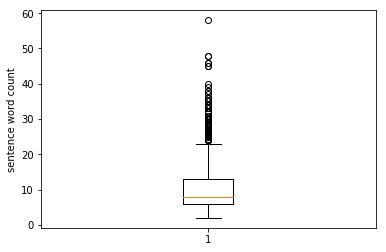

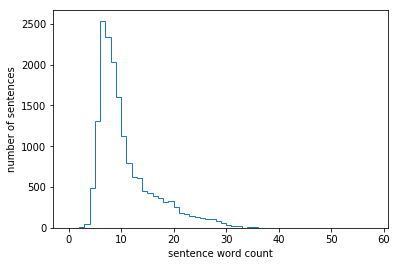

Total number of samples           n_data: 8628
Total number of sentences         n_sent: 17256    ( 2 x 8628 = 17256 )
Max words in one sentence  max_sent_wlen: 58
Max char in one sentence   max_sent_clen: 368
Total number of words            n_words: 178498
Total number of vocabulary       n_vocab: 15348
Total number of characters        n_char: 1010798


In [17]:
# Summarize sentence lengths

max_sent_clen = max(len(s) for s in sent_all)
n_char = sum(len(s) for s in sent_all)

# build keras dictionary
Ktokenizer = Tokenizer(num_words=N_VOCAB)
Ktokenizer.fit_on_texts(sent_all) 
dict_K = Ktokenizer.word_index
n_vocab = len(dict_K)

# tokenize sentences and convert words to integers for inputs
x_all = Ktokenizer.texts_to_sequences(sent_all)

slens = [len(x) for x in x_all] 
n_words = sum(slens)
max_sent_wlen = max(slens)
min_sent_wlen = min(slens)

print("Sentence word length distribution:")
print("min %d, max %d, mean %.2f, std %.2f" % (np.min(slens), np.max(slens), np.mean(slens), np.std(slens)))
n = slens.index(min_sent_wlen)
print("Shortest sentence:", n, " -- ", sent_all[n])
plt.boxplot(slens)     # boxplot to show distribution of sentence length
plt.ylabel('sentence word count')
plt.show()
plt.hist(slens, bins=max_sent_wlen, range=[0, max_sent_wlen], histtype='step')
plt.ylabel('number of sentences')
plt.xlabel('sentence word count')
plt.show()

print("Total number of samples           n_data:", n_data)
print("Total number of sentences         n_sent:", n_sent, "   ( 2 x", n_data,"=",2*n_data,")")
print("Max words in one sentence  max_sent_wlen:", max_sent_wlen)
print("Max char in one sentence   max_sent_clen:", max_sent_clen)
print("Total number of words            n_words:", n_words)
print("Total number of vocabulary       n_vocab:", n_vocab)
print("Total number of characters        n_char:", n_char)

In [18]:
# look at scores distribution

score_classes = collections.Counter(scores_all)
score_classes_sorted = sorted(score_classes)
n_score_classes = len(score_classes)
print(len(scores_all),"scores in",n_score_classes,"classes")
print(score_classes_sorted)
# scores cannot be quantized without modifying data; so treated as real numbers

8628 scores in 181 classes
[0.0, 0.067, 0.083, 0.1, 0.118, 0.133, 0.143, 0.167, 0.17, 0.188, 0.2, 0.231, 0.25, 0.267, 0.3, 0.308, 0.333, 0.364, 0.4, 0.417, 0.5, 0.533, 0.538, 0.583, 0.6, 0.636, 0.643, 0.667, 0.67, 0.727, 0.75, 0.778, 0.8, 0.833, 0.85, 0.889, 0.9, 0.944, 1.0, 1.1, 1.154, 1.2, 1.25, 1.273, 1.286, 1.3, 1.33, 1.333, 1.4, 1.5, 1.533, 1.53333333333333, 1.556, 1.583, 1.6, 1.643, 1.667, 1.67, 1.7, 1.714, 1.733, 1.75, 1.778, 1.8, 1.846, 1.9, 1.917, 2.0, 2.11111111111111, 2.167, 2.2, 2.25, 2.33, 2.333, 2.33333333333333, 2.375, 2.4, 2.46666666666667, 2.5, 2.533, 2.583, 2.588, 2.6, 2.615, 2.625, 2.647, 2.667, 2.67, 2.692, 2.7, 2.75, 2.769, 2.8, 2.812, 2.818, 2.83, 2.875, 2.909, 2.917, 3.0, 3.056, 3.067, 3.091, 3.1, 3.111, 3.167, 3.176, 3.182, 3.2, 3.231, 3.25, 3.273, 3.333, 3.33333333333333, 3.4, 3.417, 3.438, 3.444, 3.455, 3.5, 3.533, 3.538, 3.6, 3.615, 3.625, 3.643, 3.667, 3.67, 3.692, 3.714, 3.75, 3.765, 3.769, 3.77777777777778, 3.786, 3.8, 3.824, 3.833, 3.846, 3.857, 3.867, 3.

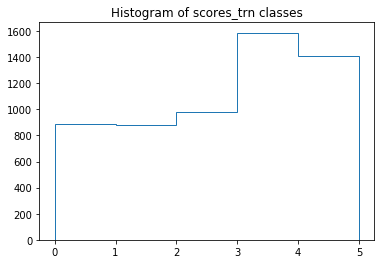

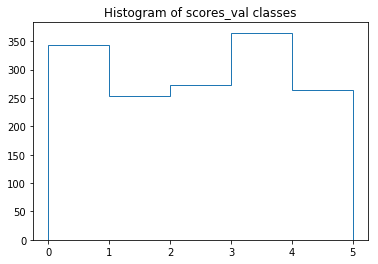

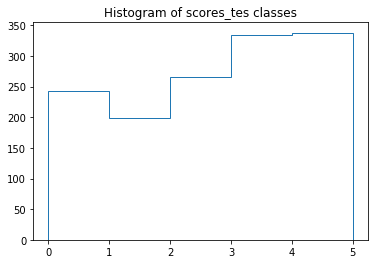

In [19]:
plt.hist(scores_trn, bins=5, range=[0, 5.0], histtype='step')
plt.title("Histogram of scores_trn classes")
plt.show()
plt.hist(scores_val, bins=5, range=[0, 5.0], histtype='step')
plt.title("Histogram of scores_val classes")
plt.show()
plt.hist(scores_tes, bins=5, range=[0, 5.0], histtype='step')
plt.title("Histogram of scores_tes classes")
plt.show()

# Load and test pre-trained GloVe embedding

In [20]:
# load the whole pre-trained embedding into memory : 400k words_glove, 100-dimension word vectors

dict_glove = dict()
f = open(fname_glove, 'r', encoding='utf-8')
print("Reading", fname_glove)
for line in f:
    values = line.split()
    w = values[0]
    wvec = np.asarray(values[1:], dtype='float64')
    dict_glove[w] = wvec

f.close()
n_glove = len(dict_glove)
print('Loaded %s word vectors.' % n_glove )


# check dictionary by printing nearest words_glove and analogous word

words_glove = list(dict_glove.keys())
wvec_glove = np.array(list(dict_glove.values()), dtype='float32')

vecn = lambda v : v / np.linalg.norm(v)
eudist = lambda u, v : np.linalg.norm(u-v)  # euclidean distance, 
                                            # no need to use this can just compare sum of squares
                                            # same result
eudist2 = lambda u, v : np.sum((u-v)*(u-v))

w2v = lambda w : dict_glove.get(w, unk_vec)

norm_glove = np.linalg.norm(wvec_glove, axis=1, keepdims=True)
wvecn_glove = wvec_glove / norm_glove

def find_nearest_eudist_word(v):
    d = [eudist2(wvec_glove[i],v) for i in range(n_glove)]
    ds = sorted(range(len(d)), key=d.__getitem__)
    return ds[0], ds[1], ds[2], ds[3], ds[4]

def find_nearest_codist_word(v):
    vn = vecn(v)
    d = [np.dot(wvecn_glove[i],vn) for i in range(n_glove)]
    ds = sorted(range(len(d)), key=d.__getitem__, reverse=True)
    return ds[0], ds[1], ds[2], ds[3], ds[4]


v = w2v("good")
r1, r2, r3, r4, r5 = find_nearest_eudist_word(v)  
print("eudist :", words_glove[r1], words_glove[r2], words_glove[r3], words_glove[r4], words_glove[r5])
r1, r2, r3, r4, r5 = find_nearest_codist_word(v)  
print("codist :", words_glove[r1], words_glove[r2], words_glove[r3], words_glove[r4], words_glove[r5])

Reading ./data/glove/glove.6B.50d.txt
Loaded 400000 word vectors.
eudist : good better always really sure
codist : good better really always sure


# Prepare embedding matrix and format input data 

(for use as weights in Keras embedding layer)

In [21]:
# Prepare embedding
print('Preparing embedding matrix.')

n_vocab = min(N_VOCAB, len(dict_K))
keras_embedding_matrix = np.zeros((n_vocab, EMBED_DIM))

for w, i in dict_K.items():
    if i >= n_vocab:    # chop of lower frequency words
        continue
    v = dict_glove.get(w)
    if v is not None:
        # words not found in embedding index will be all-zeros.
        keras_embedding_matrix[i] = v



Preparing embedding matrix.


In [22]:
print('Format data input')

x_all_pad = pad_sequences(x_all, maxlen=N_SEQ)
y_all = np.asarray(scores_all)
y_all = np.reshape(y_all,(y_all.shape[0],1))
print("x_all_pad:",type(x_all_pad), x_all_pad.shape)
print("y_all:",type(y_all), y_all.shape)

# Vectorize the text samples into a 2D integer tensor
x1_trn = x_all_pad[0:n_trn]
x1_val = x_all_pad[n_trn:n_trn+n_val]
x1_tes = x_all_pad[n_trn+n_val:n_data]
x2_trn = x_all_pad[n_data:n_data+n_trn]
x2_val = x_all_pad[n_data+n_trn:n_data+n_trn+n_val]
x2_tes = x_all_pad[n_data+n_trn+n_val:n_data*2]

y_trn = y_all[0:n_trn]
y_val = y_all[n_trn:n_trn+n_val]
y_tes = y_all[n_trn+n_val:n_data]

print("x1_trn:",type(x1_trn), x1_trn.shape)
print("x1_val:",type(x1_val), x1_val.shape)
print("x1_tes:",type(x1_tes), x1_tes.shape)
print("x2_trn:",type(x2_trn), x2_trn.shape)
print("x2_val:",type(x2_val), x2_val.shape)
print("x2_tes:",type(x2_tes), x2_tes.shape)
print("y_trn:",type(y_trn), y_trn.shape)
print("y_val:",type(y_val), y_val.shape)
print("y_tes:",type(y_tes), y_tes.shape)


Format data input
x_all_pad: <class 'numpy.ndarray'> (17256, 58)
y_all: <class 'numpy.ndarray'> (8628, 1)
x1_trn: <class 'numpy.ndarray'> (5749, 58)
x1_val: <class 'numpy.ndarray'> (1500, 58)
x1_tes: <class 'numpy.ndarray'> (1379, 58)
x2_trn: <class 'numpy.ndarray'> (5749, 58)
x2_val: <class 'numpy.ndarray'> (1500, 58)
x2_tes: <class 'numpy.ndarray'> (1379, 58)
y_trn: <class 'numpy.ndarray'> (5749, 1)
y_val: <class 'numpy.ndarray'> (1500, 1)
y_tes: <class 'numpy.ndarray'> (1379, 1)


# Build model and run

In [24]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
inp1 = Input(shape=(N_SEQ,), dtype='int32', name='inp1')
x1 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], input_length=N_SEQ, trainable=False, name='Embedding1')(inp1)
print("After embedding layer:", x1.shape)
x1 = LSTM(128, name='LSTM1')(x1)
print("After LSTM layer:", x1.shape)
x1 = Dropout(0.2, name='dropout1')(x1)

print("-------------")
inp2 = Input(shape=(N_SEQ,), dtype='int32', name='inp2')
x2 = Embedding(n_vocab, EMBED_DIM, weights=[keras_embedding_matrix], input_length=N_SEQ, trainable=False, name='Embedding2')(inp2)
print("After embedding layer:", x2.shape)
x2 = LSTM(128, name='LSTM2')(x2)
print("After LSTM layer:", x2.shape)
x2 = Dropout(0.2, name='dropout2')(x2)

print("-------------")
d = keras.layers.Subtract()([x1, x2])
print("After subtract layer:", d.shape)
output = keras.layers.dot([x1, x2], axes=1, normalize=True, name='dot')
print("Output, after dot layer:", output.shape)


After embedding layer: (?, 58, 50)
After LSTM layer: (?, 128)
-------------
After embedding layer: (?, 58, 50)
After LSTM layer: (?, 128)
-------------
After subtract layer: (?, 128)
Output, after dot layer: (?, 1)


In [25]:
model = keras.models.Model(inputs=[inp1, inp2], outputs=output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inp1 (InputLayer)                (None, 58)            0                                            
____________________________________________________________________________________________________
inp2 (InputLayer)                (None, 58)            0                                            
____________________________________________________________________________________________________
Embedding1 (Embedding)           (None, 58, 50)        767400      inp1[0][0]                       
____________________________________________________________________________________________________
Embedding2 (Embedding)           (None, 58, 50)        767400      inp2[0][0]                       
___________________________________________________________________________________________

In [26]:
# define pearson correlation as model metric

def pearson_corr(a, b):

    a_mean = K.mean(a)
    b_mean = K.mean(b)
    a_diff = a - a_mean
    b_diff = b - b_mean

    pcorr = K.sum(a_diff*b_diff)/K.sqrt(K.sum(a_diff*a_diff))/K.sqrt(K.sum(b_diff*b_diff))
    
    return pcorr


In [27]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=[pearson_corr])

In [28]:
# define the checkpoint
fname_checkpoints ="./checkpoints/weights-improvement-{epoch:02d}-{loss:.4f}-RNN-sts.hdf5"
checkpoint = ModelCheckpoint(fname_checkpoints, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [29]:
batch_size = 16
epochs = 30
hist = model.fit([x1_trn, x2_trn], y_trn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = callbacks_list,
          validation_data=([x1_val, x2_val], y_val))

Train on 5749 samples, validate on 1500 samples
Epoch 1/30
5749/5749 [==============================] - 35s - loss: 5.9204 - pearson_corr: 0.0073 - val_loss: 4.1224 - val_pearson_corr: 0.0896
Epoch 2/30
5749/5749 [==============================] - 35s - loss: 5.7691 - pearson_corr: 0.0080 - val_loss: 4.1160 - val_pearson_corr: 0.1366
Epoch 3/30
5749/5749 [==============================] - 35s - loss: 5.7625 - pearson_corr: 0.0495 - val_loss: 4.1138 - val_pearson_corr: 0.1460
Epoch 4/30
5749/5749 [==============================] - 35s - loss: 5.7642 - pearson_corr: -0.0051 - val_loss: 4.1126 - val_pearson_corr: 0.1737
Epoch 5/30
5749/5749 [==============================] - 36s - loss: 5.7618 - pearson_corr: 0.0048 - val_loss: 4.1117 - val_pearson_corr: 0.2019
Epoch 6/30
5749/5749 [==============================] - 36s - loss: 5.7640 - pearson_corr: -0.0083 - val_loss: 4.1115 - val_pearson_corr: 0.2001
Epoch 7/30
5749/5749 [==============================] - 35s - loss: 5.7630 - pearson_c

5749/5749 [==============================] - 36s - loss: 5.7632 - pearson_corr: -0.0067 - val_loss: 4.1103 - val_pearson_corr: 0.0699
Epoch 29/30
5749/5749 [==============================] - 34s - loss: 5.7606 - pearson_corr: -0.0050 - val_loss: 4.1102 - val_pearson_corr: 0.1339
Epoch 30/30
5749/5749 [==============================] - 35s - loss: 5.7567 - pearson_corr: 0.0258 - val_loss: 4.1102 - val_pearson_corr: 0.1364


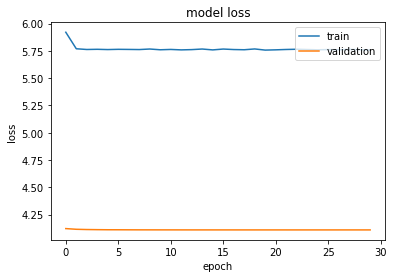

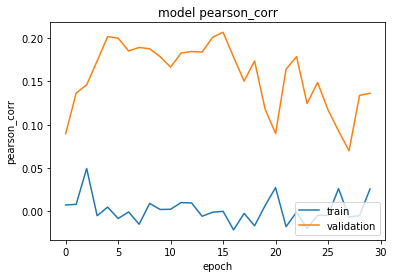

In [31]:
def plot_train(hist, metric):
    h = hist.history
    if metric == 'pearson_corr' :
        meas='pearson_corr'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    plt.show()
    
plot_train(hist, 'loss')
plot_train(hist, 'pearson_corr')


In [30]:
model.save(fname_model)

In [ ]:
model = load_model(fname_model)

In [ ]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate([x1_tes, x2_tes], y_tes, batch_size=batch_size)
print("")
print('Model mean squared error = %.2f' % (evaluation[0]))
print('Model pearson correlation = %.2f' % (evaluation[1]))


In [ ]:
batch_size = 16
epochs = 30
hist = model.fit([x1_trn, x2_trn], y_trn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = callbacks_list,
          validation_data=([x1_val, x2_val], y_val))

# Results for model 1 :

    inp1 = Input(shape=(data_x1.shape[1], data_x1.shape[2]), name='input1')
    inp2 = Input(shape=(data_x2.shape[1], data_x2.shape[2]), name='input2')

    x1 = LSTM(128, name='LSTM1')(inp1)
    x1 = Dropout(0.2, name='dropout1')(x1)

    x2 = LSTM(128, name='LSTM2')(inp2)
    x2 = Dropout(0.2, name='dropout2')(x2)

    d = keras.layers.Subtract(name='Subtract')([x1, x2])
    output = keras.layers.dot([d, d], axes=1, normalize=False, name='dot')

    ____________________________________________________________________________________________________
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    input1 (InputLayer)              (None, 62, 50)        0                                            
    ____________________________________________________________________________________________________
    input2 (InputLayer)              (None, 62, 50)        0                                            
    ____________________________________________________________________________________________________
    LSTM1 (LSTM)                     (None, 128)           91648       input1[0][0]                     
    ____________________________________________________________________________________________________
    LSTM2 (LSTM)                     (None, 128)           91648       input2[0][0]                     
    ____________________________________________________________________________________________________
    dropout1 (Dropout)               (None, 128)           0           LSTM1[0][0]                      
    ____________________________________________________________________________________________________
    dropout2 (Dropout)               (None, 128)           0           LSTM2[0][0]                      
    ____________________________________________________________________________________________________
    dot (Dot)                        (None, 1)             0           dropout1[0][0]                   
                                                                       dropout2[0][0]                   
    ====================================================================================================
    Total params: 183,296
    Trainable params: 183,296
    Non-trainable params: 0
    ____________________________________________________________________________________________________

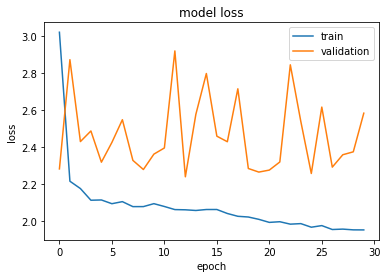


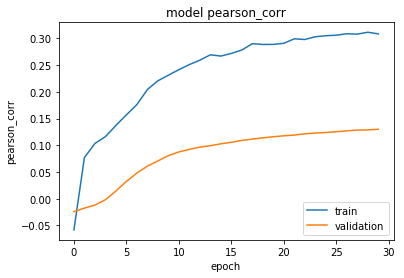

Model mean squared error = 2.31
Model mean absolute error = 1.26
Model pearson correlation = 0.12

# Results for model 2 : with dense layers between LSTM and dot


    x1 = LSTM(256, name='LSTM1')(inp1)
    x1 = Dense(128, name='dense1')(x1)
    x1 = Dropout(0.25)(x1)

    x2 = LSTM(256, name='LSTM2')(inp2)
    x2 = Dense(128, name='dense2')(x2)
    x2 = Dropout(0.25)(x2)

    d = keras.layers.Subtract()([x1, x2])
    output = keras.layers.dot([x1, x2], axes=1, normalize=False, name='dot')
    
    ____________________________________________________________________________________________________
    Layer (type)                     Output Shape          Param #     Connected to                     
    ====================================================================================================
    input1 (InputLayer)              (None, 62, 50)        0                                            
    ____________________________________________________________________________________________________
    input2 (InputLayer)              (None, 62, 50)        0                                            
    ____________________________________________________________________________________________________
    LSTM1 (LSTM)                     (None, 256)           314368      input1[0][0]                     
    ____________________________________________________________________________________________________
    LSTM2 (LSTM)                     (None, 256)           314368      input2[0][0]                     
    ____________________________________________________________________________________________________
    dense1 (Dense)                   (None, 128)           32896       LSTM1[0][0]                      
    ____________________________________________________________________________________________________
    dense2 (Dense)                   (None, 128)           32896       LSTM2[0][0]                      
    ____________________________________________________________________________________________________
    dropout_3 (Dropout)              (None, 128)           0           dense1[0][0]                     
    ____________________________________________________________________________________________________
    dropout_4 (Dropout)              (None, 128)           0           dense2[0][0]                     
    ____________________________________________________________________________________________________
    dot (Dot)                        (None, 1)             0           dropout_3[0][0]                  
                                                                       dropout_4[0][0]                  
    ====================================================================================================
    Total params: 694,528
    Trainable params: 694,528
    Non-trainable params: 0
    ____________________________________________________________________________________________________
    
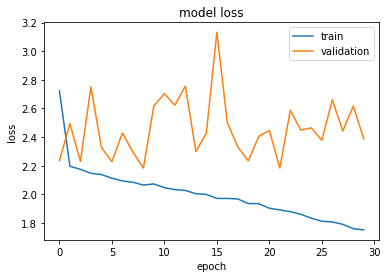
   

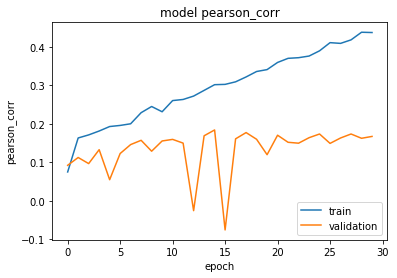

Test results: 
Model mean squared error = 2.21
Model pearson correlation = 0.18

Stats when nltk tokenizer was used:

    Total number of records    : 8628
    Total number of sentences  : 17256    ( 2 x 8628 = 17256 )
    Max words in one sentence  : 61
    Max char in one sentence   : 368
    Total number of words      : 197340
    Total number of vocabulary : 18511
    Total number of characters : 1028053


